# COMP5328 - Advanced Machine Learning

## Assignment 2: Label Noise Robustness Classifiers

Authors: Shiwen Xu, Kane Wang, ...

## 0. Runtime Setup & Package Loading

In [97]:
# import common libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable
from torchmetrics.classification import Accuracy
from torchmetrics.classification import Precision
from torchmetrics.classification import Recall
from torchmetrics.classification import F1Score

In [3]:
# colab runtime
# comment out below codes if you are using local environment
from google.colab import drive
drive.mount('/content/drive')
DATA_ROOT = "/content/drive/MyDrive/usyd/COMP5328/ass2/datasets"

Mounted at /content/drive


In [4]:
# local runtime
# DATA_ROOT = "./datasets"

In [5]:
# setup gpu for acceleration
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='cuda', index=0)

## 1. Datasets

### 1.1 Load Datasets

In [6]:
# label maps
FashionMNIST_classes = ['T-shirt/top', 'Trouser', 'Dress']
CIFAR_classes = ['plane', 'car', 'cat']

# load FashionMNIST0.5
FashionMNIST05_dataset = np.load(DATA_ROOT + os.sep + 'FashionMNIST0.5.npz')
FashionMNIST05_Xtr = FashionMNIST05_dataset['Xtr']
FashionMNIST05_Str = FashionMNIST05_dataset['Str']
FashionMNIST05_Xts = FashionMNIST05_dataset['Xts']
FashionMNIST05_Yts = FashionMNIST05_dataset['Yts']
# print the shapes
print('FashionMNIST0.5:', 'Xtr', FashionMNIST05_Xtr.shape, 'Str', FashionMNIST05_Str.shape, 'Xts', FashionMNIST05_Xts.shape, 'Yts', FashionMNIST05_Yts.shape)

# load FashionMNIST0.6
FashionMNIST06_dataset = np.load(DATA_ROOT + os.sep + 'FashionMNIST0.6.npz')
FashionMNIST06_Xtr = FashionMNIST06_dataset['Xtr']
FashionMNIST06_Str = FashionMNIST06_dataset['Str']
FashionMNIST06_Xts = FashionMNIST06_dataset['Xts']
FashionMNIST06_Yts = FashionMNIST06_dataset['Yts']
# print the shapes
print('FashionMNIST0.6:', 'Xtr', FashionMNIST06_Xtr.shape, 'Str', FashionMNIST06_Str.shape, 'Xts', FashionMNIST06_Xts.shape, 'Yts', FashionMNIST06_Yts.shape)

# load CIFAR
CIFAR_dataset = np.load(DATA_ROOT + os.sep + 'CIFAR.npz')
CIFAR_Xtr = CIFAR_dataset['Xtr']
CIFAR_Str = CIFAR_dataset['Str']
CIFAR_Xts = CIFAR_dataset['Xts']
CIFAR_Yts = CIFAR_dataset['Yts']
print('          CIFAR:', 'Xtr', CIFAR_Xtr.shape, 'Str', CIFAR_Str.shape, 'Xts', CIFAR_Xts.shape, 'Yts', CIFAR_Yts.shape)

FashionMNIST0.5: Xtr (18000, 28, 28) Str (18000,) Xts (3000, 28, 28) Yts (3000,)
FashionMNIST0.6: Xtr (18000, 28, 28) Str (18000,) Xts (3000, 28, 28) Yts (3000,)
          CIFAR: Xtr (15000, 32, 32, 3) Str (15000,) Xts (3000, 32, 32, 3) Yts (3000,)


### 1.2 Plot Noisy Data

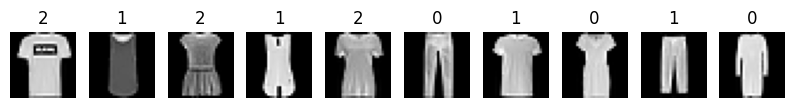

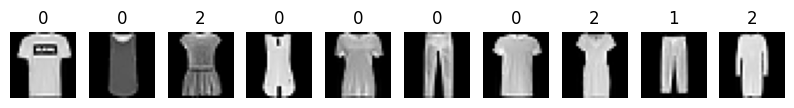

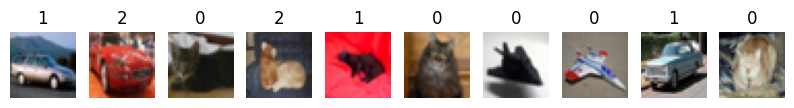

In [7]:
# plot FashionMNIST0.5 training set
fig, axes = plt.subplots(1,10,figsize=(10, 1))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(FashionMNIST05_Xtr[i,:],cmap=plt.cm.gray)
    ax.set_title(int(FashionMNIST05_Str[i]))
    ax.axis('off')
plt.show()

# plot FashionMNIST0.6 training set
fig, axes = plt.subplots(1,10,figsize=(10, 1))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(FashionMNIST06_Xtr[i,:],cmap=plt.cm.gray)
    ax.set_title(int(FashionMNIST06_Str[i]))
    ax.axis('off')
plt.show()

# plot CIFAR training set
fig, axes = plt.subplots(1,10,figsize=(10, 1))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(CIFAR_Xtr[i,:])
    ax.set_title(int(CIFAR_Str[i]))
    ax.axis('off')
plt.show()

### 1.3 Plot Clean Data

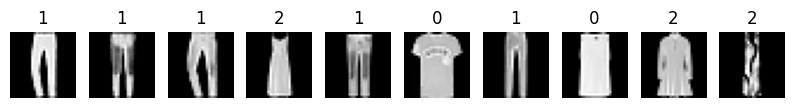

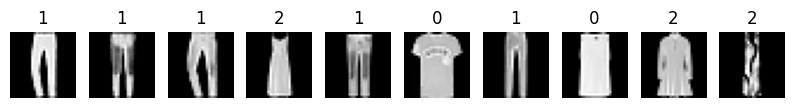

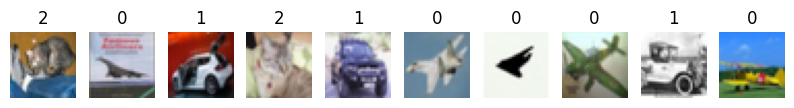

In [8]:
# plot FashionMNIST0.5 training set
fig, axes = plt.subplots(1,10,figsize=(10, 1))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(FashionMNIST05_Xts[i,:],cmap=plt.cm.gray)
    ax.set_title(int(FashionMNIST05_Yts[i]))
    ax.axis('off')
plt.show()

# plot FashionMNIST0.6 training set
fig, axes = plt.subplots(1,10,figsize=(10, 1))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(FashionMNIST06_Xts[i,:],cmap=plt.cm.gray)
    ax.set_title(int(FashionMNIST06_Yts[i]))
    ax.axis('off')
plt.show()

# plot CIFAR training set
fig, axes = plt.subplots(1,10,figsize=(10, 1))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(CIFAR_Xts[i,:])
    ax.set_title(int(CIFAR_Yts[i]))
    ax.axis('off')
plt.show()

## 2. Transition Matrix Leaner Implementation

\begin{align}
    \begin{bmatrix}
    P(\tilde{Y}=0|X=x^0) \\
    P(\tilde{Y}=1|X=x^0) \\
    P(\tilde{Y}=2|X=x^0)
    \end{bmatrix} &=
    \begin{bmatrix}
    P(\tilde{Y}=0|Y=0) &  P(\tilde{Y}=0|Y=1) &  P(\tilde{Y}=0|Y=2) \\
    P(\tilde{Y}=1|Y=0) &  P(\tilde{Y}=1|Y=1) &  P(\tilde{Y}=1|Y=2)  \\
    P(\tilde{Y}=2|Y=0) &  P(\tilde{Y}=2|Y=1) &  P(\tilde{Y}=2|Y=2)
    \end{bmatrix}
    \begin{bmatrix}
    P(Y=0|X=x^0) \\
    P(Y=1|X=x^0) \\
    P(Y=2|X=x^0)
    \end{bmatrix} \\
    &=\begin{bmatrix}
    P(\tilde{Y}=0|Y=0) &  P(\tilde{Y}=0|Y=1) &  P(\tilde{Y}=0|Y=2) \\
    P(\tilde{Y}=1|Y=0) &  P(\tilde{Y}=1|Y=1) &  P(\tilde{Y}=1|Y=2)  \\
    P(\tilde{Y}=2|Y=0) &  P(\tilde{Y}=2|Y=1) &  P(\tilde{Y}=2|Y=2)
    \end{bmatrix}
    \begin{bmatrix}
    1 \\
    0 \\
    0
    \end{bmatrix} \\
    &=\begin{bmatrix}
    P(\tilde{Y}=0|Y=0) \\
    P(\tilde{Y}=1|Y=0) \\
    P(\tilde{Y}=2|Y=0)
    \end{bmatrix}
\end{align}

In [9]:
# transition matrix learner
# this implementation is a simple extension from the binary method illustrated in week 10's tutorial
# this method estimates the transition matrix by finding the anchor points
def eval_transition_matrix(model, train_loader):
    model.eval()
    matrix = np.zeros((3,3))

    for step, (data, targets) in enumerate(train_loader):
        probs = F.softmax(model(data)[0].cpu(), dim=1).data.numpy()

        for prob in probs:
            if prob[0] > matrix[0][0]:
                matrix[0][0] = prob[0]
                matrix[1][0] = prob[1]
                matrix[2][0] = prob[2]
            if prob[1] > matrix[1][1]:
                matrix[0][1] = prob[0]
                matrix[1][1] = prob[1]
                matrix[2][1] = prob[2]
            if prob[2] > matrix[2][2]:
                matrix[0][2] = prob[0]
                matrix[1][2] = prob[1]
                matrix[2][2] = prob[2]

    return torch.tensor(matrix, dtype=torch.float32).to(device)

## 3. Classifier Implementations

### 3.1 Base CNN & Bottom Up Learning

For fair comparison, all classifers are based on the same base CNN model, but using different methods to make them robust.

This implementation consists of three components: CNN layers, Classifier layers and the Probability Transition layer. All three components can be set to frozen or unforzen. By default, the Probability Transtition layer is an identity matrix, which does not affect the output results.

By controlling the states of the components, this implementation can be used as **a standard CNN model** or **bottom up learning**.


In [108]:
# This implementation can use known transition matrix for training
# It can also learn noise distribution if the transition matrix is unknown
class NeuralNet(nn.Module):

    def __init__(self, n_channels, n_classes):
        super(NeuralNet, self).__init__()

        self.n_classes = n_classes

        self.criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 1, 1], dtype=torch.float32).to(device))

        # create convolutional layers
        self.cnn_model = nn.Sequential(
            nn.Conv2d(n_channels, 16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2)
        )

        # create the final probability output layer
        self.classifier = nn.Sequential(
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128, n_classes),
        )

        # create probability transition layer
        # by default, it's an identity matrix
        l = nn.Linear(n_classes, n_classes, bias=False)
        l.weight.data.copy_(torch.eye(n_classes))
        self.transition = nn.Sequential(l)

        self.history = {
            'evaluation_val': [],
            'evaluation_test': [],
        }

        self.best = {
            'epoch': 0,
            'evaluation_val': {
                'acc': 0,
            },
            'evaluation_test': {
                'acc': 0,
            },
        }

    # forward
    def forward(self, x):
        x = self.cnn_model(x)
        x = torch.flatten(x, 1)
        x = nn.Dropout(0.2)(x)
        x = self.classifier(x)

        # create two outputs, before and after transition
        x1 = nn.Softmax(1)(x)
        x2 = self.transition(x1)

        return x1, x2

    def fit(
            self,
            trainingloader,
            validationloader,
            testingloader,
            lr = 0.001,
            weight_decay = 0,
            n_epochs = 10,
            freeze_cnn = False,
            freeze_classifier = False,
            freeze_transition = True,
            transition_matrix = None
        ):

        # set transition layer weights if transition matrix is knonwn
        if transition_matrix is not None:
            # different from that in the lecture, the transition matrix layer is on the right hand, needs to transpose
            self.transition[0].weight.data.copy_(transition_matrix.T)



        # set optimisation function
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        # scheduler = ReduceLROnPlateau(optimizer, 'min')

        for param in self.transition.parameters():
            param.requires_grad = not freeze_transition

        for param in self.cnn_model.parameters():
            param.requires_grad = not freeze_cnn

        for param in self.classifier.parameters():
            param.requires_grad = not freeze_classifier

        # loop over the dataset multiple times
        for epoch in range(n_epochs):
            for i, data in enumerate(trainingloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data

                self.train()

                # forward + backward + optimize
                outputs_1, outputs_2 = self(inputs)

                # apply constraints to transition layer weights
                if not freeze_transition:
                    for param in self.transition.parameters():
                        param.data = self.transition_constraint(param.data)

                # Y_noise
                loss = self.loss(outputs_1, outputs_2, labels, transition_matrix)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


            # we only care about noise predition on the validation set,
            # and true prediction on the testing set
            _, evaluation_val  = self.predict(validationloader)
            evaluation_test, _ = self.predict(testingloader)

            test_acc = evaluation_test['acc']
            val_acc = evaluation_val['acc']

            self.history['evaluation_val'].append(evaluation_val)
            self.history['evaluation_test'].append(evaluation_test)

            if evaluation_test['acc'] > self.best['evaluation_test']['acc']:
                self.best['epoch'] = epoch
                self.best['evaluation_test'] = evaluation_test
                self.best['evaluation_val'] = evaluation_val

            print(f'[{epoch + 1}, {i + 1:5d}] val acc: {val_acc:.3f}, test acc: {test_acc:.3f}')

            # scheduler.step(1-val_acc)

        return self

    # restrict the column vectors sum to 1
    def transition_constraint(self, param):
        w = param.clamp(0, 1)
        w_norm = w / w.sum(dim=0, keepdim=True)
        return w_norm

    # predict and evaluate
    def predict(self, dataloader):

        y_1 = torch.tensor([], dtype=torch.int).to(device)
        y_2 = torch.tensor([], dtype=torch.int).to(device)
        y_true = torch.tensor([], dtype=torch.int).to(device)


        # since we're not training, we don't need to calculate the gradients for our outputs
        self.eval()

        for data in dataloader:
            inputs, labels = data

            # calculate outputs by running images through the network
            outputs_1, outputs_2 = self(inputs)

            # the class with the highest energy is what we choose as prediction
            _, predicted_1 = torch.max(outputs_1.data, 1)
            _, predicted_2 = torch.max(outputs_2.data, 1)


            y_1 = torch.cat((y_1, predicted_1))
            y_2 = torch.cat((y_2, predicted_2))
            y_true = torch.cat((y_true, labels))

        evaluation_1 = {
            'precision' : Precision(task="multiclass", average='macro', num_classes=3).to(device)(y_1, y_true),
            'recall' : Recall(task="multiclass", average='macro', num_classes=3).to(device)(y_1, y_true),
            'f1' : F1Score(task="multiclass", average='macro', num_classes=3).to(device)(y_1, y_true),
            'acc' : Accuracy(task="multiclass", average='macro', num_classes=3).to(device)(y_1, y_true)
        }

        evaluation_2 = {
            'precision' : Precision(task="multiclass", average='macro', num_classes=3).to(device)(y_2, y_true),
            'recall' : Recall(task="multiclass", average='macro', num_classes=3).to(device)(y_2, y_true),
            'f1' : F1Score(task="multiclass", average='macro', num_classes=3).to(device)(y_2, y_true),
            'acc' : Accuracy(task="multiclass", average='macro', num_classes=3).to(device)(y_2, y_true)
        }

        return evaluation_1, evaluation_2


    def loss(self, outputs_1, outputs_2, labels, transition_matrix):
        return self.criterion(outputs_2, labels)

### 3.2 Importance Reweighting Forward Classifier

In [109]:
# Loss Reweighting Learning
class ImportanceReweighting(NeuralNet):

    def __init__(self, n_channels = 1, n_classes = 3):
        super(ImportanceReweighting, self).__init__(n_channels, n_classes)
        self.criterion = ReweightLoss()

    # forward
    def forward(self, x):
        x = self.cnn_model(x)
        x = torch.flatten(x, 1)
        x = nn.Dropout(0.2)(x)

        # create two outputs
        x = self.classifier(x)
        return x, x

    def loss(self, outputs_1, outputs_2, labels, transition_matrix):
        return self.criterion(outputs_1, transition_matrix, labels)

# reweighting loss
class ReweightLoss(nn.Module):

    def __init__(self):
        super(ReweightLoss, self).__init__()

    def forward(self, out, T, target):
        loss = 0.
        out_softmax = F.softmax(out, dim=1)

        for i in range(len(target)):

            noise_probs = out_softmax[i]
            temp = out[i]
            temp = torch.unsqueeze(temp, 0)


            noise_probs = torch.unsqueeze(noise_probs, 0)
            true_probs = torch.matmul(noise_probs, T.t())

            # get the prob in both distribution
            # For prob1 t would be P(X=x, Y=y)
            # prob2 = P(X=x, Y_\hat = y)
            prob_noise = noise_probs[0, target[i]]
            prob_true = true_probs[0, target[i]]

            #The domain transaction nie!!!

            beta = prob_noise / prob_true

            # This part is very important that we need to track the beta's gradient
            # as out goal is minimize the differece which is the freaking core of it!!!
            beta = Variable(beta, requires_grad=True)

            # Continue with the loss computation
            cross_loss = F.cross_entropy(temp, torch.unsqueeze(target[i], 0))
            _loss = beta * cross_loss
            loss += _loss

        return loss / len(target)


### 3.3 Adaptive Sample Selection(BARE)

In [110]:
EPS = 1e-8

# Loss Reweighting Learning
class BARE(NeuralNet):

    def __init__(self, n_channels = 1, n_classes = 3):
        super(BARE, self).__init__(n_channels, n_classes)
        self.criterion = WeightedCCE(num_class = n_classes)

    # forward
    def forward(self, x):
        x = self.cnn_model(x)
        x = torch.flatten(x, 1)
        x = nn.Dropout(0.2)(x)

        # create two outputs
        x = self.classifier(x)
        return x, x

    def loss(self, outputs_1, outputs_2, labels, transition_matrix):
        return self.criterion(outputs_1, labels)


# Weighted CCE loss
class WeightedCCE(nn.Module):
    """
    Implementing BARE with Cross-Entropy (CCE) Loss
    """

    def __init__(self, k=1, num_class=3, reduction="mean"):
        super(WeightedCCE, self).__init__()

        self.k = k
        self.reduction = reduction
        self.num_class = num_class

    def forward(self, prediction, target_label, one_hot=True):
        if one_hot:
            y_true = F.one_hot(target_label.type(torch.LongTensor),
                               num_classes=self.num_class).to(device)
        y_pred = F.softmax(prediction, dim=1)
        y_pred = torch.clamp(y_pred, EPS, 1-EPS)
        pred_tmp = torch.sum(y_true * y_pred, axis=-1).reshape(-1, 1)

        ## Compute batch statistics
        avg_post = torch.mean(y_pred, dim=0)
        avg_post = avg_post.reshape(-1, 1)
        std_post = torch.std(y_pred, dim=0)
        std_post = std_post.reshape(-1, 1)
        avg_post_ref = torch.matmul(y_true.type(torch.float), avg_post)
        std_post_ref = torch.matmul(y_true.type(torch.float), std_post)
        pred_prun = torch.where((pred_tmp - avg_post_ref >= self.k * std_post_ref),
                                pred_tmp, torch.zeros_like(pred_tmp))

        # prun_idx will tell us which examples are
        # 'trustworthy' for the given batch
        prun_idx = torch.where(pred_prun != 0.)[0]
        if len(prun_idx) != 0:
            prun_targets = torch.argmax(torch.index_select(y_true, 0, prun_idx), dim=1)
            weighted_loss = F.cross_entropy(torch.index_select(prediction, 0, prun_idx),
                                            prun_targets, reduction=self.reduction)
        else:
            weighted_loss = F.cross_entropy(prediction, target_label)
        return weighted_loss

## 4. Experiments

### 4.0 Trainloader and Testloader

In [13]:
# all three datasets have three classes
classes = (0,1,2)
batch_size = 64

# normalise the data, reshape the data to match pytorch cnn format
FashionMNIST05_Xtr = torch.nn.functional.normalize(torch.tensor(np.moveaxis(np.reshape(FashionMNIST05_Xtr,(18000,28,28,1)), 3, 1), dtype=torch.float32)).to(device)
FashionMNIST05_Str = torch.tensor(FashionMNIST05_Str, dtype=torch.int64).to(device)
FashionMNIST05_Xts = torch.nn.functional.normalize(torch.tensor(np.moveaxis(np.reshape(FashionMNIST05_Xts,(3000,28,28,1)), 3, 1), dtype=torch.float32)).to(device)
FashionMNIST05_Yts = torch.tensor(FashionMNIST05_Yts, dtype=torch.int64).to(device)

# create pytorch training and testing dataset
FashionMNIST05_trainset = TensorDataset(FashionMNIST05_Xtr,FashionMNIST05_Str)
FashionMNIST05_testset = TensorDataset(FashionMNIST05_Xts,FashionMNIST05_Yts)

# prepare test loader
FashionMNIST05_trainloader = DataLoader(FashionMNIST05_trainset, batch_size=batch_size, shuffle=True)
FashionMNIST05_testloader = DataLoader(FashionMNIST05_testset, batch_size=batch_size, shuffle=False)


# normalise the data, reshape the data to match pytorch cnn format
FashionMNIST06_Xtr = torch.nn.functional.normalize(torch.tensor(np.moveaxis(np.reshape(FashionMNIST06_Xtr,(18000,28,28,1)), 3, 1), dtype=torch.float32)).to(device)
FashionMNIST06_Str = torch.tensor(FashionMNIST06_Str, dtype=torch.int64).to(device)
FashionMNIST06_Xts = torch.nn.functional.normalize(torch.tensor(np.moveaxis(np.reshape(FashionMNIST06_Xts,(3000,28,28,1)), 3, 1), dtype=torch.float32)).to(device)
FashionMNIST06_Yts = torch.tensor(FashionMNIST06_Yts, dtype=torch.int64).to(device)

# create pytorch training and testing dataset
FashionMNIST06_trainset = TensorDataset(FashionMNIST06_Xtr,FashionMNIST06_Str)
FashionMNIST06_testset = TensorDataset(FashionMNIST06_Xts,FashionMNIST06_Yts)

# prepare test loader
FashionMNIST06_trainloader = DataLoader(FashionMNIST06_trainset, batch_size=batch_size, shuffle=True)
FashionMNIST06_testloader = DataLoader(FashionMNIST06_testset, batch_size=batch_size, shuffle=False)


# normalise the data, reshape the data to match pytorch cnn format
CIFAR_Xtr = torch.nn.functional.normalize(torch.tensor(np.moveaxis(CIFAR_Xtr, 3, 1), dtype=torch.float32)).to(device)
CIFAR_Str = torch.tensor(CIFAR_Str, dtype=torch.int64).to(device)
CIFAR_Xts = torch.nn.functional.normalize(torch.tensor(np.moveaxis(CIFAR_Xts, 3, 1), dtype=torch.float32)).to(device)
CIFAR_Yts = torch.tensor(CIFAR_Yts, dtype=torch.int64).to(device)

# create pytorch training and testing dataset
CIFAR_trainset = TensorDataset(CIFAR_Xtr,CIFAR_Str)
CIFAR_testset = TensorDataset(CIFAR_Xts,CIFAR_Yts)

# prepare test loader
CIFAR_trainloader = DataLoader(CIFAR_trainset, batch_size=batch_size, shuffle=True)
CIFAR_testloader = DataLoader(CIFAR_testset, batch_size=batch_size, shuffle=False)

# the given transition matrices
FashionMNIST05_transition_matrix = torch.tensor([
    [0.5, 0.2, 0.3],
    [0.3, 0.5, 0.2],
    [0.2, 0.3, 0.5]
], dtype=torch.float32).to(device)

FashionMNIST06_transition_matrix = torch.tensor([
    [0.4, 0.3, 0.3],
    [0.3, 0.4, 0.3],
    [0.3, 0.3, 0.4]
], dtype=torch.float32).to(device)

In [14]:
# fit models on randomly sampled subsets
# calculate metric avgs and stds
def train_models(trainfunc, trainset, testloader, transition_matrix, lr = 0.001, weight_decay = 0, n_times = 5, batch_size = 64):
    models = []
    best_acc = []
    best_precision = []
    best_recall = []
    best_f1 = []
    best_top1_acc = []
    evaluation = []
    val_split_rate = 0.1

    for i in range(n_times):
        print('training model', str(i + 1))

        # split training set to training and validation sets
        generator = torch.Generator()
        train, val = torch.utils.data.random_split(trainset, [1 - val_split_rate, val_split_rate],generator=generator)
        trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
        validationloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)

        # fit the model
        m = trainfunc(trainloader, validationloader, testloader, transition_matrix, lr, weight_decay)
        models.append(m)

        # save best performance
        best_acc.append(m.best['evaluation_test']['acc'].cpu())
        best_precision.append(m.best['evaluation_test']['precision'].cpu())
        best_recall.append(m.best['evaluation_test']['recall'].cpu())
        best_f1.append(m.best['evaluation_test']['f1'].cpu())


    # calculate avgs and stds
    acc_avg = np.average(best_acc)
    acc_std = np.std(best_acc)
    precision_avg = np.average(best_precision)
    precision_std = np.std(best_precision)
    recall_avg = np.average(best_recall)
    recall_std = np.std(best_recall)
    f1_avg = np.average(best_f1)
    f1_std = np.std(best_f1)

    evaluation = {
        'acc_avg': acc_avg,
        'acc_std': acc_std,
        'precision_avg': precision_avg,
        'precision_std': precision_std,
        'recall_avg': recall_avg,
        'recall_std': recall_std,
        'f1_avg': f1_avg,
        'f1_std': f1_std,
    }

    print('training finished.')
    return models, evaluation


In [113]:
n_repeats = 10
n_epochs = 40

### 4.1 Base CNN, FashionMNIST05

In [114]:
base_f05_models, base_f05_metrics = train_models(
    lambda trainloader, validationloader, testloader, transition_matrix, lr, weight_decay: (
        NeuralNet(n_channels=1,n_classes=3)
        .to(device)
        .fit(trainloader, validationloader, testloader, n_epochs=n_epochs, lr=lr, freeze_transition=True)
    ),
    FashionMNIST05_trainset,
    FashionMNIST05_testloader,
    transition_matrix=None,
    lr=0.001,
    weight_decay=0,
    n_times=n_repeats
)
base_f05_metrics

training model 1
[1,   254] val acc: 0.463, test acc: 0.847
[2,   254] val acc: 0.466, test acc: 0.875
[3,   254] val acc: 0.463, test acc: 0.893
[4,   254] val acc: 0.465, test acc: 0.900
[5,   254] val acc: 0.468, test acc: 0.880
[6,   254] val acc: 0.459, test acc: 0.887
[7,   254] val acc: 0.466, test acc: 0.902
[8,   254] val acc: 0.468, test acc: 0.898
[9,   254] val acc: 0.474, test acc: 0.901
[10,   254] val acc: 0.461, test acc: 0.864
[11,   254] val acc: 0.477, test acc: 0.910
[12,   254] val acc: 0.470, test acc: 0.916
[13,   254] val acc: 0.472, test acc: 0.927
[14,   254] val acc: 0.468, test acc: 0.892
[15,   254] val acc: 0.476, test acc: 0.924
[16,   254] val acc: 0.476, test acc: 0.920
[17,   254] val acc: 0.476, test acc: 0.926
[18,   254] val acc: 0.474, test acc: 0.930
[19,   254] val acc: 0.473, test acc: 0.917
[20,   254] val acc: 0.471, test acc: 0.917
[21,   254] val acc: 0.474, test acc: 0.924
[22,   254] val acc: 0.472, test acc: 0.914
[23,   254] val acc: 0.4

{'acc_avg': 0.93640006,
 'acc_std': 0.0026449251,
 'precision_avg': 0.93723613,
 'precision_std': 0.0027499732,
 'recall_avg': 0.93640006,
 'recall_std': 0.0026449251,
 'f1_avg': 0.93660605,
 'f1_std': 0.002633558}

In [115]:
# estimate the transition matrix
eval_transition_matrix(base_f05_models[0],FashionMNIST05_trainloader)

tensor([[0.5761, 0.2124, 0.2137],
        [0.2119, 0.5749, 0.2143],
        [0.2119, 0.2128, 0.5720]], device='cuda:0')

### 4.2 Forward Learning, FashionMNIST05

In [116]:
# importance reweighting forward learning model, with known transition matrix
irfl_f05_models, irfl_f05_metrics = train_models(
    lambda trainloader, validationloader, testloader, transition_matrix, lr, weight_decay: (
        NeuralNet(n_channels=1,n_classes=3).
        to(device).
        fit(trainloader,validationloader,testloader,n_epochs=n_epochs,lr=lr,freeze_transition=True,transition_matrix=transition_matrix)
    ),
    FashionMNIST05_trainset,
    FashionMNIST05_testloader,
    FashionMNIST05_transition_matrix,
    lr=0.001,
    weight_decay=0,
    n_times=n_repeats
)
irfl_f05_metrics

training model 1
[1,   254] val acc: 0.397, test acc: 0.521
[2,   254] val acc: 0.458, test acc: 0.838
[3,   254] val acc: 0.408, test acc: 0.565
[4,   254] val acc: 0.413, test acc: 0.566
[5,   254] val acc: 0.392, test acc: 0.477
[6,   254] val acc: 0.408, test acc: 0.563
[7,   254] val acc: 0.402, test acc: 0.538
[8,   254] val acc: 0.403, test acc: 0.583
[9,   254] val acc: 0.403, test acc: 0.586
[10,   254] val acc: 0.409, test acc: 0.580
[11,   254] val acc: 0.396, test acc: 0.507
[12,   254] val acc: 0.406, test acc: 0.584
[13,   254] val acc: 0.400, test acc: 0.586
[14,   254] val acc: 0.402, test acc: 0.588
[15,   254] val acc: 0.406, test acc: 0.592
[16,   254] val acc: 0.405, test acc: 0.585
[17,   254] val acc: 0.406, test acc: 0.587
[18,   254] val acc: 0.411, test acc: 0.589
[19,   254] val acc: 0.404, test acc: 0.589
[20,   254] val acc: 0.409, test acc: 0.593
[21,   254] val acc: 0.407, test acc: 0.595
[22,   254] val acc: 0.405, test acc: 0.587
[23,   254] val acc: 0.4

{'acc_avg': 0.8911667,
 'acc_std': 0.019137096,
 'precision_avg': 0.89498633,
 'precision_std': 0.01946298,
 'recall_avg': 0.8911667,
 'recall_std': 0.019137096,
 'f1_avg': 0.89198893,
 'f1_std': 0.019256948}

### 4.3 Bottom Up Learning, FashionMNIST05

In [117]:
# Bottom Up learning model
bu_f05_models, bu_f05_metrics = train_models(
    lambda trainloader, validationloader, testloader, transition_matrix, lr, weight_decay: (
        NeuralNet(n_channels=1,n_classes=3)
        .to(device)
        # train the model with the fixed identity transition layer
        .fit(trainloader, validationloader, testloader, n_epochs=int(n_epochs/2), lr=lr, freeze_transition=True)
        # train the model with the free transition layer
        .fit(trainloader, validationloader, testloader, n_epochs=int(n_epochs/2), lr=lr, freeze_transition=False)
    ),
    FashionMNIST05_trainset,
    FashionMNIST05_testloader,
    None,
    lr=0.001,
    weight_decay=0,
    n_times=n_repeats
)
bu_f05_metrics

training model 1
[1,   254] val acc: 0.463, test acc: 0.834
[2,   254] val acc: 0.468, test acc: 0.872
[3,   254] val acc: 0.470, test acc: 0.880
[4,   254] val acc: 0.452, test acc: 0.837
[5,   254] val acc: 0.461, test acc: 0.889
[6,   254] val acc: 0.461, test acc: 0.859
[7,   254] val acc: 0.470, test acc: 0.912
[8,   254] val acc: 0.467, test acc: 0.912
[9,   254] val acc: 0.469, test acc: 0.910
[10,   254] val acc: 0.468, test acc: 0.904
[11,   254] val acc: 0.471, test acc: 0.916
[12,   254] val acc: 0.468, test acc: 0.920
[13,   254] val acc: 0.459, test acc: 0.885
[14,   254] val acc: 0.469, test acc: 0.928
[15,   254] val acc: 0.473, test acc: 0.925
[16,   254] val acc: 0.470, test acc: 0.905
[17,   254] val acc: 0.475, test acc: 0.928
[18,   254] val acc: 0.471, test acc: 0.921
[19,   254] val acc: 0.473, test acc: 0.922
[20,   254] val acc: 0.473, test acc: 0.928
[1,   254] val acc: 0.473, test acc: 0.933
[2,   254] val acc: 0.476, test acc: 0.931
[3,   254] val acc: 0.472,

{'acc_avg': 0.9368001,
 'acc_std': 0.0028836725,
 'precision_avg': 0.9375886,
 'precision_std': 0.003064735,
 'recall_avg': 0.9368001,
 'recall_std': 0.0028836725,
 'f1_avg': 0.9370289,
 'f1_std': 0.0029108354}

### 4.4 Importance Reweighting, FashionMNIST05


In [118]:
# Loss Reweighting Learning Model
lr_f05_models, lr_f05_metrics = train_models(
    lambda trainloader, validationloader, testloader, transition_matrix, lr, weight_decay: (
        ImportanceReweighting(n_channels=1,n_classes=3)
        .to(device)
        .fit(trainloader,validationloader,testloader,n_epochs=n_epochs,lr=lr,freeze_transition=True,transition_matrix=transition_matrix)
    ),
    FashionMNIST05_trainset,
    FashionMNIST05_testloader,
    FashionMNIST05_transition_matrix,
    lr=0.0001,
    weight_decay=0.00001,
    n_times=n_repeats
)
lr_f05_metrics

training model 1
[1,   254] val acc: 0.439, test acc: 0.749
[2,   254] val acc: 0.439, test acc: 0.731
[3,   254] val acc: 0.438, test acc: 0.759
[4,   254] val acc: 0.456, test acc: 0.825
[5,   254] val acc: 0.458, test acc: 0.776
[6,   254] val acc: 0.453, test acc: 0.834
[7,   254] val acc: 0.456, test acc: 0.842
[8,   254] val acc: 0.456, test acc: 0.849
[9,   254] val acc: 0.455, test acc: 0.866
[10,   254] val acc: 0.462, test acc: 0.867
[11,   254] val acc: 0.464, test acc: 0.871
[12,   254] val acc: 0.455, test acc: 0.868
[13,   254] val acc: 0.471, test acc: 0.877
[14,   254] val acc: 0.459, test acc: 0.872
[15,   254] val acc: 0.457, test acc: 0.888
[16,   254] val acc: 0.461, test acc: 0.894
[17,   254] val acc: 0.467, test acc: 0.896
[18,   254] val acc: 0.463, test acc: 0.895
[19,   254] val acc: 0.467, test acc: 0.892
[20,   254] val acc: 0.461, test acc: 0.898
[21,   254] val acc: 0.465, test acc: 0.898
[22,   254] val acc: 0.464, test acc: 0.903
[23,   254] val acc: 0.4

{'acc_avg': 0.9102667,
 'acc_std': 0.0022000002,
 'precision_avg': 0.9161647,
 'precision_std': 0.002707234,
 'recall_avg': 0.9102667,
 'recall_std': 0.0022000002,
 'f1_avg': 0.91120356,
 'f1_std': 0.002168285}

### 4.5 BARE, FashionMNIST05

In [119]:
bare_f05_models, bare_f05_metrics = train_models(
    lambda trainloader, validationloader, testloader, transition_matrix, lr, weight_decay: (
        BARE(n_channels=1,n_classes=3)
        .to(device)
        .fit(trainloader, validationloader, testloader, n_epochs=200, lr=lr, freeze_transition=True)
    ),
    FashionMNIST05_trainset,
    FashionMNIST05_testloader,
    transition_matrix=None,
    lr=0.001,
    weight_decay=0,
    n_times=n_repeats
)
bare_f05_metrics

training model 1
[1,   254] val acc: 0.344, test acc: 0.356
[2,   254] val acc: 0.364, test acc: 0.495
[3,   254] val acc: 0.401, test acc: 0.605
[4,   254] val acc: 0.363, test acc: 0.492
[5,   254] val acc: 0.396, test acc: 0.496
[6,   254] val acc: 0.364, test acc: 0.471
[7,   254] val acc: 0.379, test acc: 0.545
[8,   254] val acc: 0.355, test acc: 0.462
[9,   254] val acc: 0.389, test acc: 0.512
[10,   254] val acc: 0.367, test acc: 0.498
[11,   254] val acc: 0.352, test acc: 0.405
[12,   254] val acc: 0.365, test acc: 0.495
[13,   254] val acc: 0.358, test acc: 0.483
[14,   254] val acc: 0.364, test acc: 0.490
[15,   254] val acc: 0.364, test acc: 0.492
[16,   254] val acc: 0.369, test acc: 0.498
[17,   254] val acc: 0.364, test acc: 0.503
[18,   254] val acc: 0.363, test acc: 0.494
[19,   254] val acc: 0.360, test acc: 0.477
[20,   254] val acc: 0.357, test acc: 0.484
[21,   254] val acc: 0.372, test acc: 0.508
[22,   254] val acc: 0.362, test acc: 0.493
[23,   254] val acc: 0.3

{'acc_avg': 0.83640003,
 'acc_std': 0.17184469,
 'precision_avg': 0.83395624,
 'precision_std': 0.19176333,
 'recall_avg': 0.83640003,
 'recall_std': 0.17184469,
 'f1_avg': 0.83378,
 'f1_std': 0.18254212}

### 4.6 Base CNN, FashionMNIST06

In [120]:
base_f06_models, base_f06_metrics = train_models(
    lambda trainloader, validationloader, testloader, transition_matrix, lr, weight_decay: (
        NeuralNet(n_channels=1,n_classes=3)
        .to(device)
        .fit(trainloader, validationloader, testloader, n_epochs=n_epochs, lr=lr, freeze_transition=True)
    ),
    FashionMNIST06_trainset,
    FashionMNIST06_testloader,
    transition_matrix=None,
    lr=0.001,
    weight_decay=0,
    n_times=n_repeats
)
base_f06_metrics

training model 1
[1,   254] val acc: 0.338, test acc: 0.338
[2,   254] val acc: 0.362, test acc: 0.802
[3,   254] val acc: 0.359, test acc: 0.747
[4,   254] val acc: 0.365, test acc: 0.831
[5,   254] val acc: 0.354, test acc: 0.745
[6,   254] val acc: 0.345, test acc: 0.677
[7,   254] val acc: 0.356, test acc: 0.877
[8,   254] val acc: 0.360, test acc: 0.880
[9,   254] val acc: 0.357, test acc: 0.845
[10,   254] val acc: 0.360, test acc: 0.884
[11,   254] val acc: 0.359, test acc: 0.879
[12,   254] val acc: 0.356, test acc: 0.859
[13,   254] val acc: 0.360, test acc: 0.867
[14,   254] val acc: 0.356, test acc: 0.874
[15,   254] val acc: 0.363, test acc: 0.879
[16,   254] val acc: 0.351, test acc: 0.864
[17,   254] val acc: 0.352, test acc: 0.852
[18,   254] val acc: 0.358, test acc: 0.879
[19,   254] val acc: 0.358, test acc: 0.869
[20,   254] val acc: 0.355, test acc: 0.877
[21,   254] val acc: 0.366, test acc: 0.874
[22,   254] val acc: 0.354, test acc: 0.842
[23,   254] val acc: 0.3

{'acc_avg': 0.89156663,
 'acc_std': 0.0031869595,
 'precision_avg': 0.89961654,
 'precision_std': 0.00246681,
 'recall_avg': 0.89156663,
 'recall_std': 0.0031869595,
 'f1_avg': 0.89270556,
 'f1_std': 0.0031425958}

In [121]:
# estimate the transition matrix
eval_transition_matrix(base_f06_models[0],FashionMNIST06_trainloader)

tensor([[0.5504, 0.2192, 0.2120],
        [0.2280, 0.5490, 0.2119],
        [0.2216, 0.2318, 0.5761]], device='cuda:0')

### 4.7 Forward Learning, FashionMNIST06

In [122]:
# importance reweighting forward learning model, with known transition matrix
irfl_f06_models, irfl_f06_metrics = train_models(
    lambda trainloader, validationloader, testloader, transition_matrix, lr, weight_decay: (
        NeuralNet(n_channels=1,n_classes=3).
        to(device).
        fit(trainloader,validationloader,testloader,n_epochs=n_epochs,lr=lr,freeze_transition=True,transition_matrix=transition_matrix)
    ),
    FashionMNIST06_trainset,
    FashionMNIST06_testloader,
    FashionMNIST06_transition_matrix,
    lr=0.001,
    weight_decay=0,
    n_times=n_repeats
)
irfl_f06_metrics

training model 1
[1,   254] val acc: 0.333, test acc: 0.333
[2,   254] val acc: 0.350, test acc: 0.516
[3,   254] val acc: 0.365, test acc: 0.763
[4,   254] val acc: 0.364, test acc: 0.835
[5,   254] val acc: 0.359, test acc: 0.877
[6,   254] val acc: 0.366, test acc: 0.866
[7,   254] val acc: 0.361, test acc: 0.876
[8,   254] val acc: 0.360, test acc: 0.880
[9,   254] val acc: 0.361, test acc: 0.886
[10,   254] val acc: 0.355, test acc: 0.867
[11,   254] val acc: 0.356, test acc: 0.841
[12,   254] val acc: 0.359, test acc: 0.841
[13,   254] val acc: 0.361, test acc: 0.875
[14,   254] val acc: 0.352, test acc: 0.635
[15,   254] val acc: 0.359, test acc: 0.813
[16,   254] val acc: 0.359, test acc: 0.849
[17,   254] val acc: 0.351, test acc: 0.692
[18,   254] val acc: 0.358, test acc: 0.875
[19,   254] val acc: 0.362, test acc: 0.880
[20,   254] val acc: 0.360, test acc: 0.857
[21,   254] val acc: 0.363, test acc: 0.874
[22,   254] val acc: 0.362, test acc: 0.888
[23,   254] val acc: 0.3

{'acc_avg': 0.5366333,
 'acc_std': 0.21729884,
 'precision_avg': 0.4148895,
 'precision_std': 0.32417393,
 'recall_avg': 0.5366333,
 'recall_std': 0.21729884,
 'f1_avg': 0.43141112,
 'f1_std': 0.2882984}

### 4.8 Bottom Up Learning, FashionMNIST06

In [123]:
# Bottom Up learning model
bu_f06_models, bu_f06_metrics = train_models(
    lambda trainloader, validationloader, testloader, transition_matrix, lr, weight_decay: (
        NeuralNet(n_channels=1,n_classes=3)
        .to(device)
        # train the model with the fixed identity transition layer
        .fit(trainloader, validationloader, testloader, n_epochs=int(n_epochs/2), lr=lr, freeze_transition=True)
        # train the model with the free transition layer
        .fit(trainloader, validationloader, testloader, n_epochs=int(n_epochs/2), lr=lr, freeze_transition=False)
    ),
    FashionMNIST06_trainset,
    FashionMNIST06_testloader,
    None,
    lr=0.001,
    weight_decay=0,
    n_times=n_repeats
)
bu_f06_metrics

training model 1
[1,   254] val acc: 0.331, test acc: 0.356
[2,   254] val acc: 0.359, test acc: 0.761
[3,   254] val acc: 0.344, test acc: 0.695
[4,   254] val acc: 0.355, test acc: 0.844
[5,   254] val acc: 0.369, test acc: 0.869
[6,   254] val acc: 0.362, test acc: 0.835
[7,   254] val acc: 0.358, test acc: 0.761
[8,   254] val acc: 0.360, test acc: 0.882
[9,   254] val acc: 0.354, test acc: 0.873
[10,   254] val acc: 0.359, test acc: 0.877
[11,   254] val acc: 0.364, test acc: 0.886
[12,   254] val acc: 0.356, test acc: 0.877
[13,   254] val acc: 0.355, test acc: 0.798
[14,   254] val acc: 0.356, test acc: 0.859
[15,   254] val acc: 0.360, test acc: 0.890
[16,   254] val acc: 0.362, test acc: 0.889
[17,   254] val acc: 0.359, test acc: 0.878
[18,   254] val acc: 0.362, test acc: 0.789
[19,   254] val acc: 0.357, test acc: 0.870
[20,   254] val acc: 0.357, test acc: 0.886
[1,   254] val acc: 0.357, test acc: 0.874
[2,   254] val acc: 0.354, test acc: 0.844
[3,   254] val acc: 0.365,

{'acc_avg': 0.8937333,
 'acc_std': 0.0048849056,
 'precision_avg': 0.90117276,
 'precision_std': 0.0033789482,
 'recall_avg': 0.8937333,
 'recall_std': 0.0048849056,
 'f1_avg': 0.8948568,
 'f1_std': 0.0047418154}

### 4.9 Importance Reweighting, FashionMNIST06


In [124]:
# Loss Reweighting Learning Model
lr_f06_models, lr_f06_metrics = train_models(
    lambda trainloader, validationloader, testloader, transition_matrix, lr, weight_decay: (
        ImportanceReweighting(n_channels=1,n_classes=3)
        .to(device)
        .fit(trainloader,validationloader,testloader,n_epochs=n_epochs,lr=lr,freeze_transition=True,transition_matrix=transition_matrix)
    ),
    FashionMNIST06_trainset,
    FashionMNIST06_testloader,
    FashionMNIST06_transition_matrix,
    lr=0.0001,
    weight_decay=0,
    n_times=n_repeats
)
lr_f06_metrics

training model 1
[1,   254] val acc: 0.356, test acc: 0.674
[2,   254] val acc: 0.361, test acc: 0.707
[3,   254] val acc: 0.352, test acc: 0.708
[4,   254] val acc: 0.371, test acc: 0.762
[5,   254] val acc: 0.361, test acc: 0.814
[6,   254] val acc: 0.358, test acc: 0.837
[7,   254] val acc: 0.361, test acc: 0.834
[8,   254] val acc: 0.355, test acc: 0.851
[9,   254] val acc: 0.353, test acc: 0.855
[10,   254] val acc: 0.361, test acc: 0.808
[11,   254] val acc: 0.353, test acc: 0.856
[12,   254] val acc: 0.361, test acc: 0.858
[13,   254] val acc: 0.361, test acc: 0.874
[14,   254] val acc: 0.356, test acc: 0.863
[15,   254] val acc: 0.358, test acc: 0.862
[16,   254] val acc: 0.364, test acc: 0.853
[17,   254] val acc: 0.361, test acc: 0.873
[18,   254] val acc: 0.358, test acc: 0.847
[19,   254] val acc: 0.358, test acc: 0.872
[20,   254] val acc: 0.357, test acc: 0.875
[21,   254] val acc: 0.359, test acc: 0.875
[22,   254] val acc: 0.359, test acc: 0.880
[23,   254] val acc: 0.3

{'acc_avg': 0.87766665,
 'acc_std': 0.004158003,
 'precision_avg': 0.88806283,
 'precision_std': 0.0034394434,
 'recall_avg': 0.87766665,
 'recall_std': 0.004158003,
 'f1_avg': 0.8791889,
 'f1_std': 0.0039775628}

### 4.10 BARE, FashionMNIST06

In [141]:
bare_f06_models, bare_f06_metrics = train_models(
    lambda trainloader, validationloader, testloader, transition_matrix, lr, weight_decay: (
        BARE(n_channels=1,n_classes=3)
        .to(device)
        .fit(trainloader, validationloader, testloader, n_epochs=200, lr=lr, freeze_transition=True)
    ),
    FashionMNIST06_trainset,
    FashionMNIST06_testloader,
    transition_matrix=None,
    lr=0.001,
    weight_decay=0,
    n_times=n_repeats
)
bare_f06_metrics

training model 1
[1,   254] val acc: 0.336, test acc: 0.209
[2,   254] val acc: 0.317, test acc: 0.136
[3,   254] val acc: 0.329, test acc: 0.235
[4,   254] val acc: 0.331, test acc: 0.239
[5,   254] val acc: 0.329, test acc: 0.254
[6,   254] val acc: 0.328, test acc: 0.213
[7,   254] val acc: 0.324, test acc: 0.277
[8,   254] val acc: 0.327, test acc: 0.288
[9,   254] val acc: 0.328, test acc: 0.278
[10,   254] val acc: 0.323, test acc: 0.267
[11,   254] val acc: 0.332, test acc: 0.226
[12,   254] val acc: 0.324, test acc: 0.247
[13,   254] val acc: 0.322, test acc: 0.265
[14,   254] val acc: 0.323, test acc: 0.265
[15,   254] val acc: 0.331, test acc: 0.284
[16,   254] val acc: 0.331, test acc: 0.170
[17,   254] val acc: 0.326, test acc: 0.263
[18,   254] val acc: 0.319, test acc: 0.277
[19,   254] val acc: 0.323, test acc: 0.293
[20,   254] val acc: 0.325, test acc: 0.298
[21,   254] val acc: 0.321, test acc: 0.289
[22,   254] val acc: 0.319, test acc: 0.285
[23,   254] val acc: 0.3

{'acc_avg': 0.61123335,
 'acc_std': 0.25597242,
 'precision_avg': 0.57614195,
 'precision_std': 0.29341444,
 'recall_avg': 0.61123335,
 'recall_std': 0.25597242,
 'f1_avg': 0.5873383,
 'f1_std': 0.27904347}

### 4.11 Base CNN, CIFAR

In [148]:
base_ci_models, base_ci_metrics = train_models(
    lambda trainloader, validationloader, testloader, transition_matrix, lr, weight_decay: (
        NeuralNet(n_channels=3,n_classes=3)
        .to(device)
        .fit(trainloader, validationloader, testloader, n_epochs=n_epochs, lr=lr, freeze_transition=True)
    ),
    CIFAR_trainset,
    CIFAR_testloader,
    transition_matrix=None,
    lr=0.001,
    weight_decay=0,
    n_times=n_repeats
)
base_ci_metrics

training model 1
[1,   211] val acc: 0.333, test acc: 0.333
[2,   211] val acc: 0.347, test acc: 0.370
[3,   211] val acc: 0.333, test acc: 0.333
[4,   211] val acc: 0.333, test acc: 0.333
[5,   211] val acc: 0.335, test acc: 0.374
[6,   211] val acc: 0.333, test acc: 0.336
[7,   211] val acc: 0.345, test acc: 0.467
[8,   211] val acc: 0.345, test acc: 0.367
[9,   211] val acc: 0.359, test acc: 0.513
[10,   211] val acc: 0.331, test acc: 0.352
[11,   211] val acc: 0.373, test acc: 0.565
[12,   211] val acc: 0.363, test acc: 0.505
[13,   211] val acc: 0.339, test acc: 0.398
[14,   211] val acc: 0.344, test acc: 0.538
[15,   211] val acc: 0.371, test acc: 0.596
[16,   211] val acc: 0.359, test acc: 0.599
[17,   211] val acc: 0.365, test acc: 0.564
[18,   211] val acc: 0.359, test acc: 0.607
[19,   211] val acc: 0.370, test acc: 0.568
[20,   211] val acc: 0.365, test acc: 0.614
[21,   211] val acc: 0.382, test acc: 0.577
[22,   211] val acc: 0.366, test acc: 0.573
[23,   211] val acc: 0.3

{'acc_avg': 0.6181667,
 'acc_std': 0.012929943,
 'precision_avg': 0.6265862,
 'precision_std': 0.012631936,
 'recall_avg': 0.6181667,
 'recall_std': 0.012929943,
 'f1_avg': 0.6133858,
 'f1_std': 0.015123277}

In [ ]:
# estimate the transition matrix
CIFAR_transition_matrix = eval_transition_matrix(base_ci_models[0],CIFAR_trainloader)
CIFAR_transition_matrix

### 4.12 Forward Learning, CIFAR

In [149]:
# importance reweighting forward learning model, with known transition matrix
irfl_ci_models, irfl_ci_metrics = train_models(
    lambda trainloader, validationloader, testloader, transition_matrix, lr, weight_decay: (
        NeuralNet(n_channels=3,n_classes=3).
        to(device).
        fit(trainloader,validationloader,testloader,n_epochs=n_epochs,lr=lr,freeze_transition=True,transition_matrix=transition_matrix)
    ),
    CIFAR_trainset,
    CIFAR_testloader,
    CIFAR_transition_matrix,
    lr=0.001,
    weight_decay=0,
    n_times=n_repeats
)
irfl_ci_metrics

training model 1
[1,   211] val acc: 0.333, test acc: 0.333
[2,   211] val acc: 0.336, test acc: 0.320
[3,   211] val acc: 0.337, test acc: 0.330
[4,   211] val acc: 0.338, test acc: 0.343
[5,   211] val acc: 0.334, test acc: 0.334
[6,   211] val acc: 0.333, test acc: 0.333
[7,   211] val acc: 0.333, test acc: 0.333
[8,   211] val acc: 0.333, test acc: 0.333
[9,   211] val acc: 0.333, test acc: 0.333
[10,   211] val acc: 0.333, test acc: 0.333
[11,   211] val acc: 0.333, test acc: 0.333
[12,   211] val acc: 0.333, test acc: 0.333
[13,   211] val acc: 0.333, test acc: 0.333
[14,   211] val acc: 0.333, test acc: 0.333
[15,   211] val acc: 0.333, test acc: 0.333
[16,   211] val acc: 0.333, test acc: 0.333
[17,   211] val acc: 0.333, test acc: 0.333
[18,   211] val acc: 0.333, test acc: 0.333
[19,   211] val acc: 0.333, test acc: 0.333
[20,   211] val acc: 0.333, test acc: 0.333
[21,   211] val acc: 0.333, test acc: 0.333
[22,   211] val acc: 0.333, test acc: 0.333
[23,   211] val acc: 0.3

{'acc_avg': 0.466,
 'acc_std': 0.09006467,
 'precision_avg': 0.40869603,
 'precision_std': 0.1537135,
 'recall_avg': 0.466,
 'recall_std': 0.09006467,
 'f1_avg': 0.3682139,
 'f1_std': 0.13099146}

### 4.13 Bottom Up Learning, CIFAR

In [150]:
# Bottom Up learning model
bu_ci_models, bu_ci_metrics = train_models(
    lambda trainloader, validationloader, testloader, transition_matrix, lr, weight_decay: (
        NeuralNet(n_channels=3,n_classes=3)
        .to(device)
        # train the model with the fixed identity transition layer
        .fit(trainloader, validationloader, testloader, n_epochs=int(n_epochs/2), lr=lr, freeze_transition=True)
        # train the model with the free transition layer
        .fit(trainloader, validationloader, testloader, n_epochs=int(n_epochs/2), lr=lr, freeze_transition=False)
    ),
    CIFAR_trainset,
    CIFAR_testloader,
    None,
    lr=0.001,
    weight_decay=0,
    n_times=n_repeats
)
bu_ci_metrics

training model 1
[1,   211] val acc: 0.344, test acc: 0.420
[2,   211] val acc: 0.344, test acc: 0.456
[3,   211] val acc: 0.357, test acc: 0.495
[4,   211] val acc: 0.347, test acc: 0.378
[5,   211] val acc: 0.337, test acc: 0.414
[6,   211] val acc: 0.365, test acc: 0.584
[7,   211] val acc: 0.369, test acc: 0.604
[8,   211] val acc: 0.376, test acc: 0.584
[9,   211] val acc: 0.365, test acc: 0.566
[10,   211] val acc: 0.358, test acc: 0.550
[11,   211] val acc: 0.352, test acc: 0.566
[12,   211] val acc: 0.358, test acc: 0.478
[13,   211] val acc: 0.370, test acc: 0.608
[14,   211] val acc: 0.353, test acc: 0.578
[15,   211] val acc: 0.364, test acc: 0.605
[16,   211] val acc: 0.355, test acc: 0.426
[17,   211] val acc: 0.348, test acc: 0.504
[18,   211] val acc: 0.357, test acc: 0.585
[19,   211] val acc: 0.370, test acc: 0.588
[20,   211] val acc: 0.360, test acc: 0.584
[1,   211] val acc: 0.364, test acc: 0.521
[2,   211] val acc: 0.366, test acc: 0.606
[3,   211] val acc: 0.373,

{'acc_avg': 0.6153,
 'acc_std': 0.018229682,
 'precision_avg': 0.6264103,
 'precision_std': 0.02314653,
 'recall_avg': 0.6153,
 'recall_std': 0.018229682,
 'f1_avg': 0.6097754,
 'f1_std': 0.018237375}

### 4.14 Importance Reweighting, CIFAR

In [151]:
# Loss Reweighting Learning Model
lr_ci_models, lr_ci_metrics = train_models(
    lambda trainloader, validationloader, testloader, transition_matrix, lr, weight_decay: (
        ImportanceReweighting(n_channels=3,n_classes=3)
        .to(device)
        .fit(trainloader,validationloader,testloader,n_epochs=n_epochs,lr=lr,freeze_transition=True,transition_matrix=transition_matrix)
    ),
    CIFAR_trainset,
    CIFAR_testloader,
    CIFAR_transition_matrix,
    lr=0.0001,
    weight_decay=0,
    n_times=n_repeats
)
lr_ci_metrics

training model 1
[1,   211] val acc: 0.333, test acc: 0.333
[2,   211] val acc: 0.341, test acc: 0.438
[3,   211] val acc: 0.350, test acc: 0.444
[4,   211] val acc: 0.365, test acc: 0.512
[5,   211] val acc: 0.366, test acc: 0.545
[6,   211] val acc: 0.343, test acc: 0.440
[7,   211] val acc: 0.363, test acc: 0.445
[8,   211] val acc: 0.366, test acc: 0.516
[9,   211] val acc: 0.371, test acc: 0.546
[10,   211] val acc: 0.375, test acc: 0.560
[11,   211] val acc: 0.377, test acc: 0.547
[12,   211] val acc: 0.379, test acc: 0.558
[13,   211] val acc: 0.379, test acc: 0.568
[14,   211] val acc: 0.379, test acc: 0.551
[15,   211] val acc: 0.374, test acc: 0.547
[16,   211] val acc: 0.372, test acc: 0.563
[17,   211] val acc: 0.371, test acc: 0.525
[18,   211] val acc: 0.352, test acc: 0.391
[19,   211] val acc: 0.360, test acc: 0.497
[20,   211] val acc: 0.351, test acc: 0.522
[21,   211] val acc: 0.362, test acc: 0.491
[22,   211] val acc: 0.367, test acc: 0.547
[23,   211] val acc: 0.3

{'acc_avg': 0.57593334,
 'acc_std': 0.006902172,
 'precision_avg': 0.582981,
 'precision_std': 0.006335002,
 'recall_avg': 0.57593334,
 'recall_std': 0.006902172,
 'f1_avg': 0.57024497,
 'f1_std': 0.008093659}

### 4.15 BEAR, CIFAR

In [152]:
# importance reweighting forward learning model, with known transition matrix
bare_ci_models, bare_ci_metrics = train_models(
    lambda trainloader, validationloader, testloader, transition_matrix, lr, weight_decay: (
        BARE(n_channels=3,n_classes=3).
        to(device).
        fit(trainloader,validationloader,testloader,n_epochs=200,lr=lr,freeze_transition=True,transition_matrix=transition_matrix)
    ),
    CIFAR_trainset,
    CIFAR_testloader,
    None,
    lr=0.001,
    weight_decay=0,
    n_times=n_repeats
)
bare_ci_metrics

training model 1
[1,   211] val acc: 0.302, test acc: 0.189
[2,   211] val acc: 0.316, test acc: 0.244
[3,   211] val acc: 0.312, test acc: 0.247
[4,   211] val acc: 0.309, test acc: 0.192
[5,   211] val acc: 0.318, test acc: 0.216
[6,   211] val acc: 0.308, test acc: 0.208
[7,   211] val acc: 0.329, test acc: 0.348
[8,   211] val acc: 0.316, test acc: 0.380
[9,   211] val acc: 0.321, test acc: 0.422
[10,   211] val acc: 0.321, test acc: 0.473
[11,   211] val acc: 0.313, test acc: 0.407
[12,   211] val acc: 0.313, test acc: 0.356
[13,   211] val acc: 0.314, test acc: 0.443
[14,   211] val acc: 0.319, test acc: 0.375
[15,   211] val acc: 0.316, test acc: 0.399
[16,   211] val acc: 0.307, test acc: 0.376
[17,   211] val acc: 0.321, test acc: 0.306
[18,   211] val acc: 0.323, test acc: 0.342
[19,   211] val acc: 0.318, test acc: 0.359
[20,   211] val acc: 0.312, test acc: 0.423
[21,   211] val acc: 0.325, test acc: 0.362
[22,   211] val acc: 0.318, test acc: 0.364
[23,   211] val acc: 0.3

{'acc_avg': 0.52000004,
 'acc_std': 0.060740802,
 'precision_avg': 0.51870644,
 'precision_std': 0.06649768,
 'recall_avg': 0.52000004,
 'recall_std': 0.060740802,
 'f1_avg': 0.50833833,
 'f1_std': 0.062069193}

## 5 Evaluation

### 5.1 Plot Funtion

In [136]:
# plot history
def plot_history(models, metric):
    plt.figure(figsize = (8,6))
    plt.ylim([0, 1])

    ids = list(range(0,200,5))

    for ms in models:
        label = ms['name']
        evaluations = []

        for m in ms['models']:
            results = {
                'acc':[],
                'precision':[],
                'recall':[],
                'f1':[]
            }

            for result in m.history['evaluation_test']:
                for name in ('acc','precision','recall','f1'):
                    results[name].append(float(result[name].cpu()))

            evaluations.append(results)

        mean_points = np.mean([eva[metric] for eva in evaluations], axis=0)
        max_points = np.max([eva[metric] for eva in evaluations], axis=0)
        min_points = np.min([eva[metric] for eva in evaluations], axis=0)

        # shrink the variation
        max_points = 0.5 * (max_points + mean_points)
        min_points = 0.5 * (min_points + mean_points)


        if len(mean_points) > 40:
            mean_points = mean_points[ids]
            max_points = max_points[ids]
            min_points = min_points[ids]


        plt.fill_between(range(len(mean_points)),max_points,min_points, alpha=0.2)
        plt.plot(mean_points, label=label, linewidth=0.5, alpha=1)

    plt.xlabel('Epoch')
    plt.ylabel('')
    plt.legend()
    plt.show()

### 5.2 FashionMNIST05

#### 5.2.1 Top 1 Accuracy

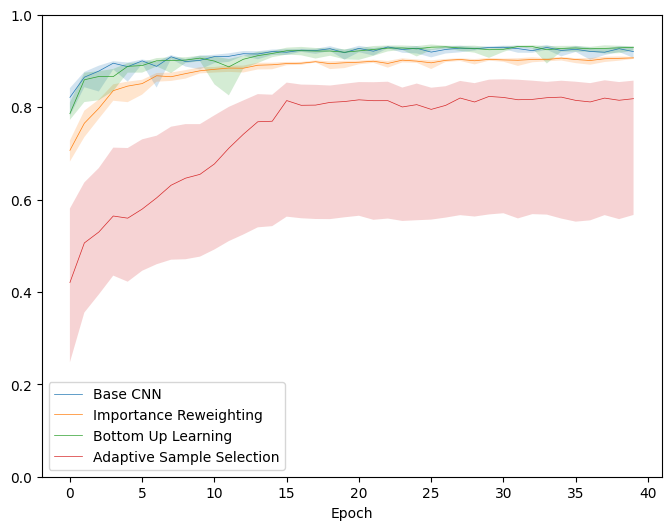

In [137]:
plot_history([
    {'name':'Base CNN', 'models':base_f05_models},
    {'name':'Importance Reweighting', 'models':lr_f05_models},
    {'name':'Bottom Up Learning', 'models':bu_f05_models},
    {'name':'Adaptive Sample Selection', 'models':bare_f05_models},
], 'acc')

#### 5.2.2 Precision

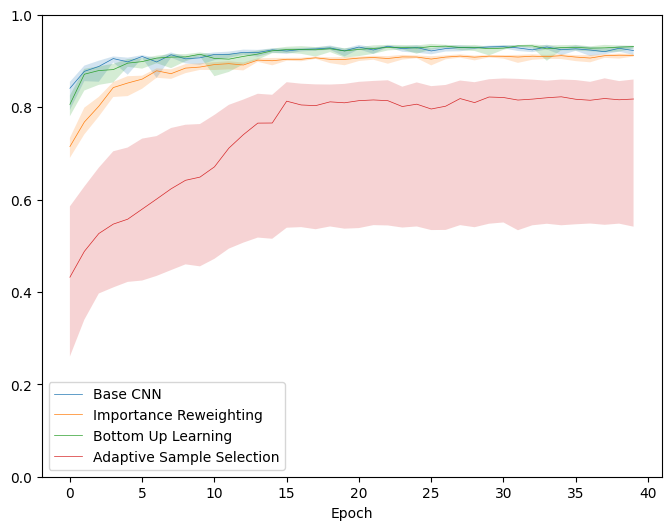

In [138]:
plot_history([
    {'name':'Base CNN', 'models':base_f05_models},
    {'name':'Importance Reweighting', 'models':lr_f05_models},
    {'name':'Bottom Up Learning', 'models':bu_f05_models},
    {'name':'Adaptive Sample Selection', 'models':bare_f05_models},
], 'precision')

#### 5.2.3 Recall

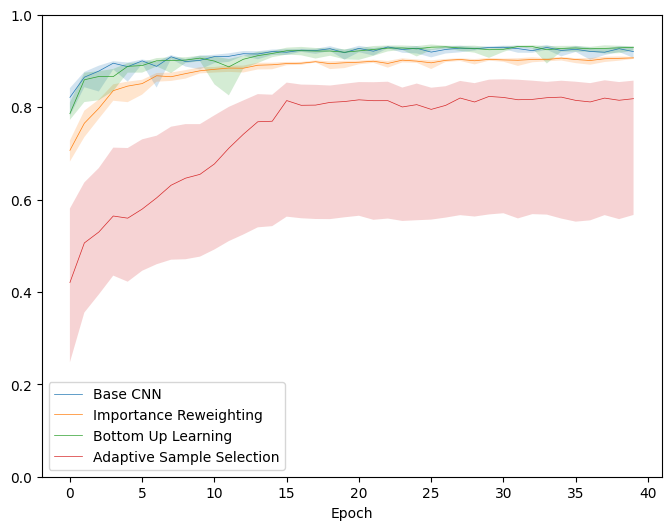

In [139]:
plot_history([
    {'name':'Base CNN', 'models':base_f05_models},
    {'name':'Importance Reweighting', 'models':lr_f05_models},
    {'name':'Bottom Up Learning', 'models':bu_f05_models},
    {'name':'Adaptive Sample Selection', 'models':bare_f05_models},
], 'recall')

#### 5.2.4 F1

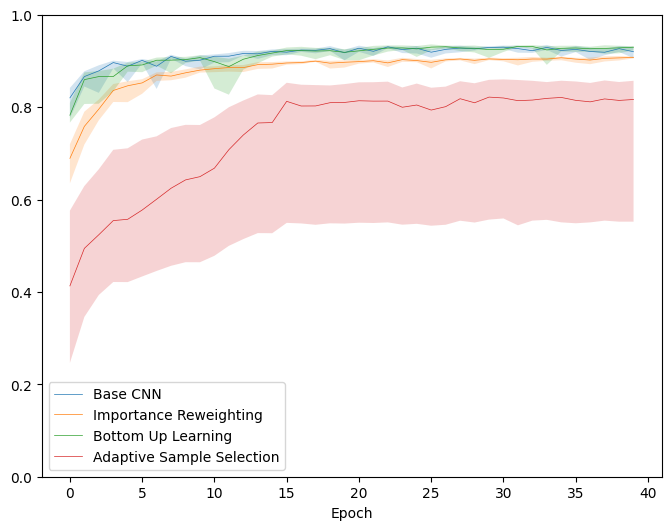

In [140]:
plot_history([
    {'name':'Base CNN', 'models':base_f05_models},
    {'name':'Importance Reweighting', 'models':lr_f05_models},
    {'name':'Bottom Up Learning', 'models':bu_f05_models},
    {'name':'Adaptive Sample Selection', 'models':bare_f05_models},
], 'f1')

### 5.3 FashionMNIST06

#### 5.3.1 Top 1 Accuracy

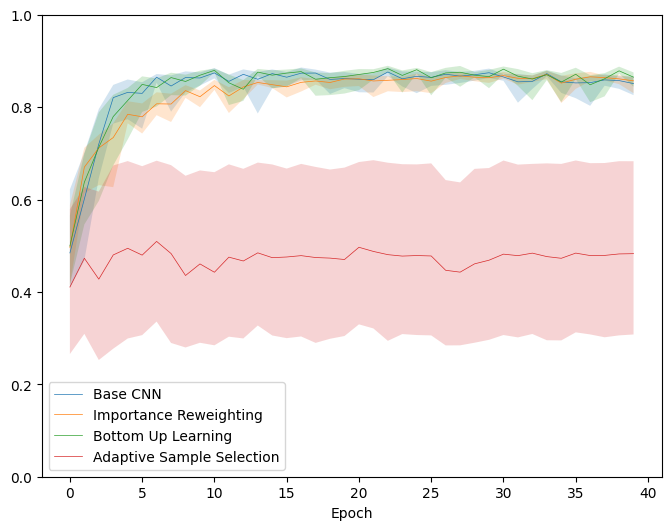

In [143]:
plot_history([
    {'name':'Base CNN', 'models':base_f06_models},
    {'name':'Importance Reweighting', 'models':lr_f06_models},
    {'name':'Bottom Up Learning', 'models':bu_f06_models},
    {'name':'Adaptive Sample Selection', 'models':bare_f06_models},
], 'acc')

#### 5.3.2 Precision

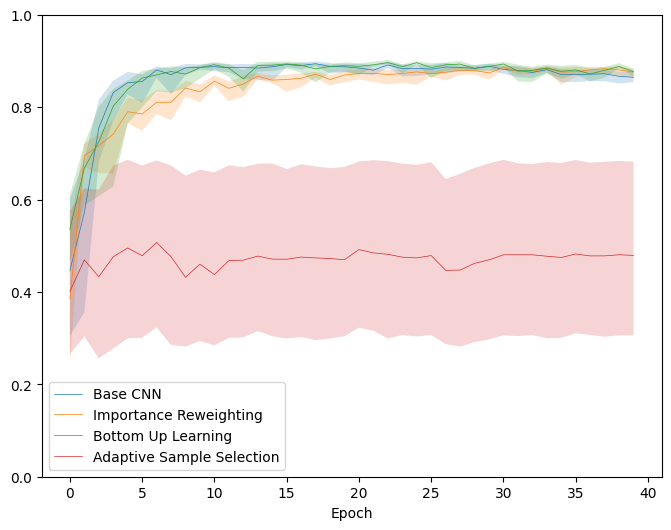

In [147]:
plot_history([
    {'name':'Base CNN', 'models':base_f06_models},
    {'name':'Importance Reweighting', 'models':lr_f06_models},
    {'name':'Bottom Up Learning', 'models':bu_f06_models},
    {'name':'Adaptive Sample Selection', 'models':bare_f06_models},
], 'precision')

#### 5.3.3 Recall

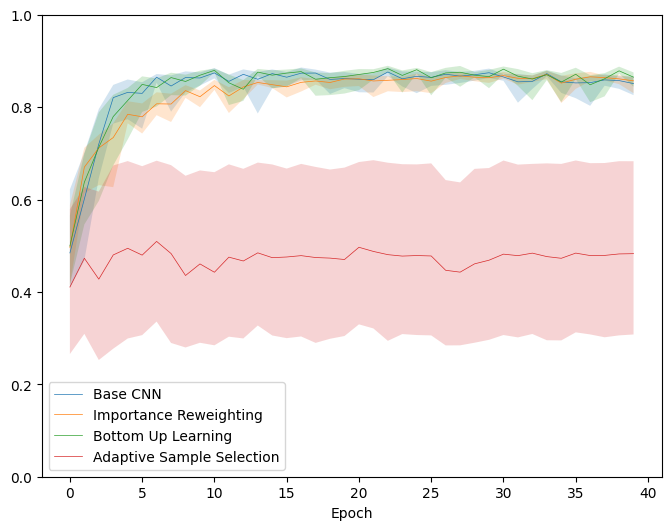

In [145]:
plot_history([
    {'name':'Base CNN', 'models':base_f06_models},
    {'name':'Importance Reweighting', 'models':lr_f06_models},
    {'name':'Bottom Up Learning', 'models':bu_f06_models},
    {'name':'Adaptive Sample Selection', 'models':bare_f06_models},
], 'recall')

#### 5.3.4 F1

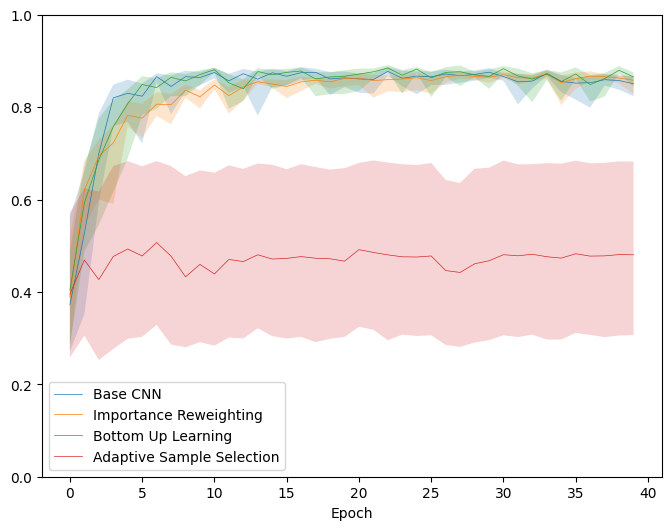

In [146]:
plot_history([
    {'name':'Base CNN', 'models':base_f06_models},
    {'name':'Importance Reweighting', 'models':lr_f06_models},
    {'name':'Bottom Up Learning', 'models':bu_f06_models},
    {'name':'Adaptive Sample Selection', 'models':bare_f06_models},
], 'f1')

### 5.4 CIFAR

#### 5.4.1 Top 1 Accuracy

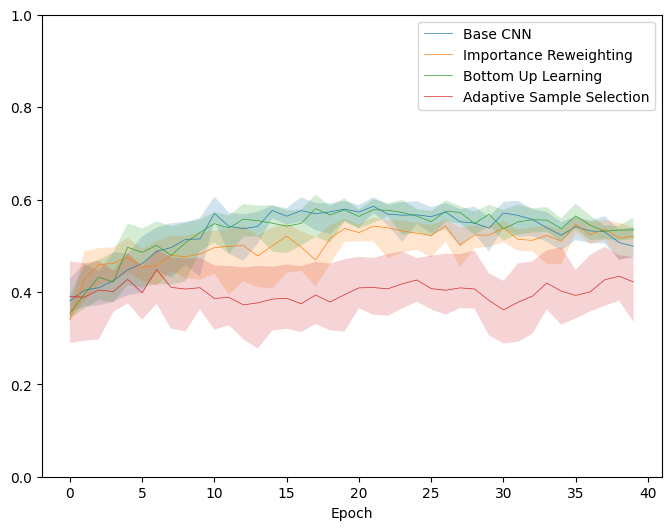

In [153]:
plot_history([
    {'name':'Base CNN', 'models':base_ci_models},
    {'name':'Importance Reweighting', 'models':lr_ci_models},
    {'name':'Bottom Up Learning', 'models':bu_ci_models},
    {'name':'Adaptive Sample Selection', 'models':bare_ci_models},
], 'acc')

#### 5.4.2 Precision

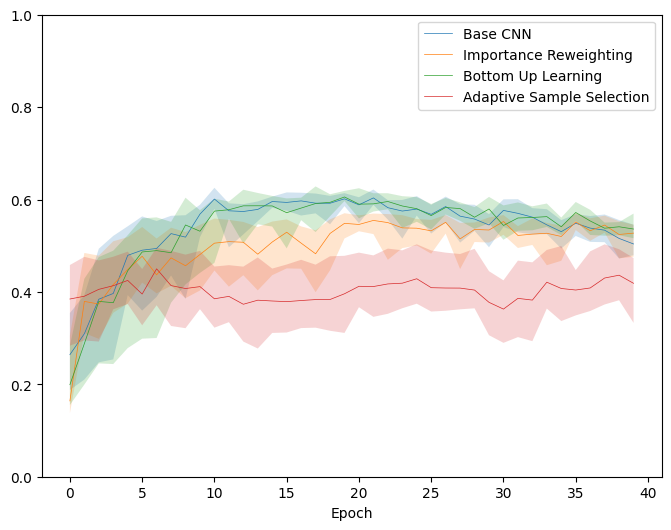

In [154]:
plot_history([
    {'name':'Base CNN', 'models':base_ci_models},
    {'name':'Importance Reweighting', 'models':lr_ci_models},
    {'name':'Bottom Up Learning', 'models':bu_ci_models},
    {'name':'Adaptive Sample Selection', 'models':bare_ci_models},
], 'precision')

#### 5.4.3 Recall

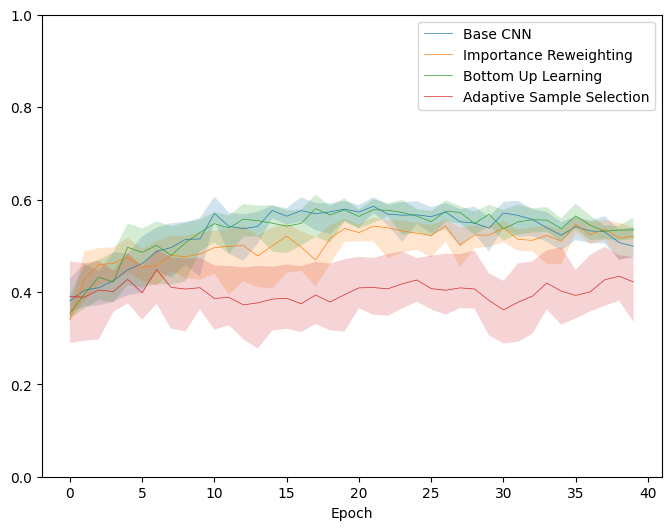

In [155]:
plot_history([
    {'name':'Base CNN', 'models':base_ci_models},
    {'name':'Importance Reweighting', 'models':lr_ci_models},
    {'name':'Bottom Up Learning', 'models':bu_ci_models},
    {'name':'Adaptive Sample Selection', 'models':bare_ci_models},
], 'recall')

#### 5.4.4 F1

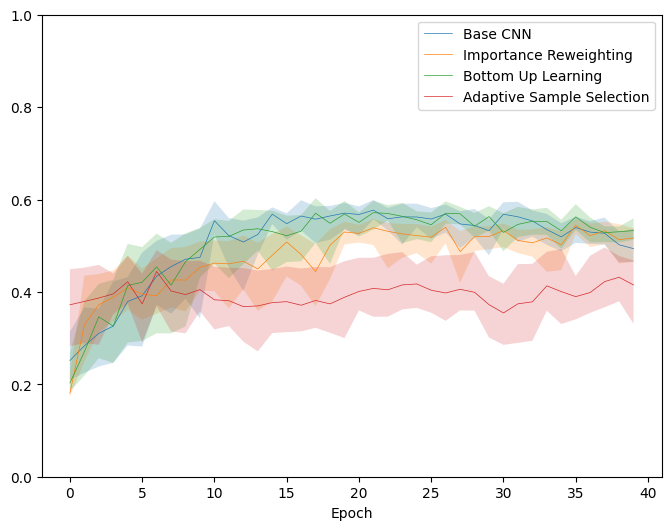

In [156]:
plot_history([
    {'name':'Base CNN', 'models':base_ci_models},
    {'name':'Importance Reweighting', 'models':lr_ci_models},
    {'name':'Bottom Up Learning', 'models':bu_ci_models},
    {'name':'Adaptive Sample Selection', 'models':bare_ci_models},
], 'f1')